# Vehicle Routing Problem with Time Windows
This notebook contains an example of how to use the PyVRP library to solve the Vehicle Routing Problem with Time Windows (VRPTW). The VRPTW can be described on a directed graph $G=(V,E)$, where $V$ is the vertex set and $E$ is the edge set. The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ represents the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers. Each customer $i \in V_c$ has a demand $q_i \geq 0$. A distance $d_{ij}$ is associated with each edge $(i, j) \in E$. We assume that we have an unlimited fleet of homogeneous vehicles with capacity $Q$ located at the depot. A feasible solution to the CVRP is a set of routes, each served by a single vehicle, such that each customer is served exactly once and none of the routes exceed the vehicle capacity. The goal is to minimize the total distance traveled.


In the following, we will show how to configure the Hybrid Genetic Search algorithm to solve three different VRPTW instances. Moreover, we demonstrate how to use plotting and diagnostics utilities from the PyVRP library to analyze the results.

## Basic example
We'll start with a basic example that loads an instance and solves it using a standard configuration. First, let's import some necessary components.

In [1]:
from typing import Optional
from pathlib import Path
from IPython.display import display

import matplotlib.pyplot as plt
import pandas as pd
import vrplib

from pyvrp import (
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    PenaltyManager,
    Population,
    ProblemData,
    XorShift128,
    diagnostics,
    plotting,
    read,
)
from pyvrp.crossover import selective_route_exchange as srex
from pyvrp.diversity import broken_pairs_distance as bpd
from pyvrp.educate import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    compute_neighbours,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

### Read and plot instance
We will first load one of the classical Solomon instances. We use the function `pyvrp.read`, which reads the instance file and converts it to a `ProblemData` instance. We pass the following arguments: 

- `instance_format='solomon'`: this parses the instance file as a Solomon formatted instance (as opposed to VRPLIB formatted instances),
- `round_func='trunc1'`: this compute distances with 1 decimal precision, by multipliying all distances by 10 and converting to integers (i.e., following the [DIMACS VRP challenge](http://dimacs.rutgers.edu/programs/challenge/vrp/) convention).

In [2]:
instance = read(
    "data/RC208.vrp", instance_format="solomon", round_func="trunc1"
)
instance_bks = vrplib.read_solution("data/RC208.sol")

Let's plot the instance and see what we have. The function `plotting.plot_instance` will plot time windows, demands and coordinates, which should give us a good impression of what the instance looks like (note that these can also be plotted separately using the `plotting.plot_*` functions.

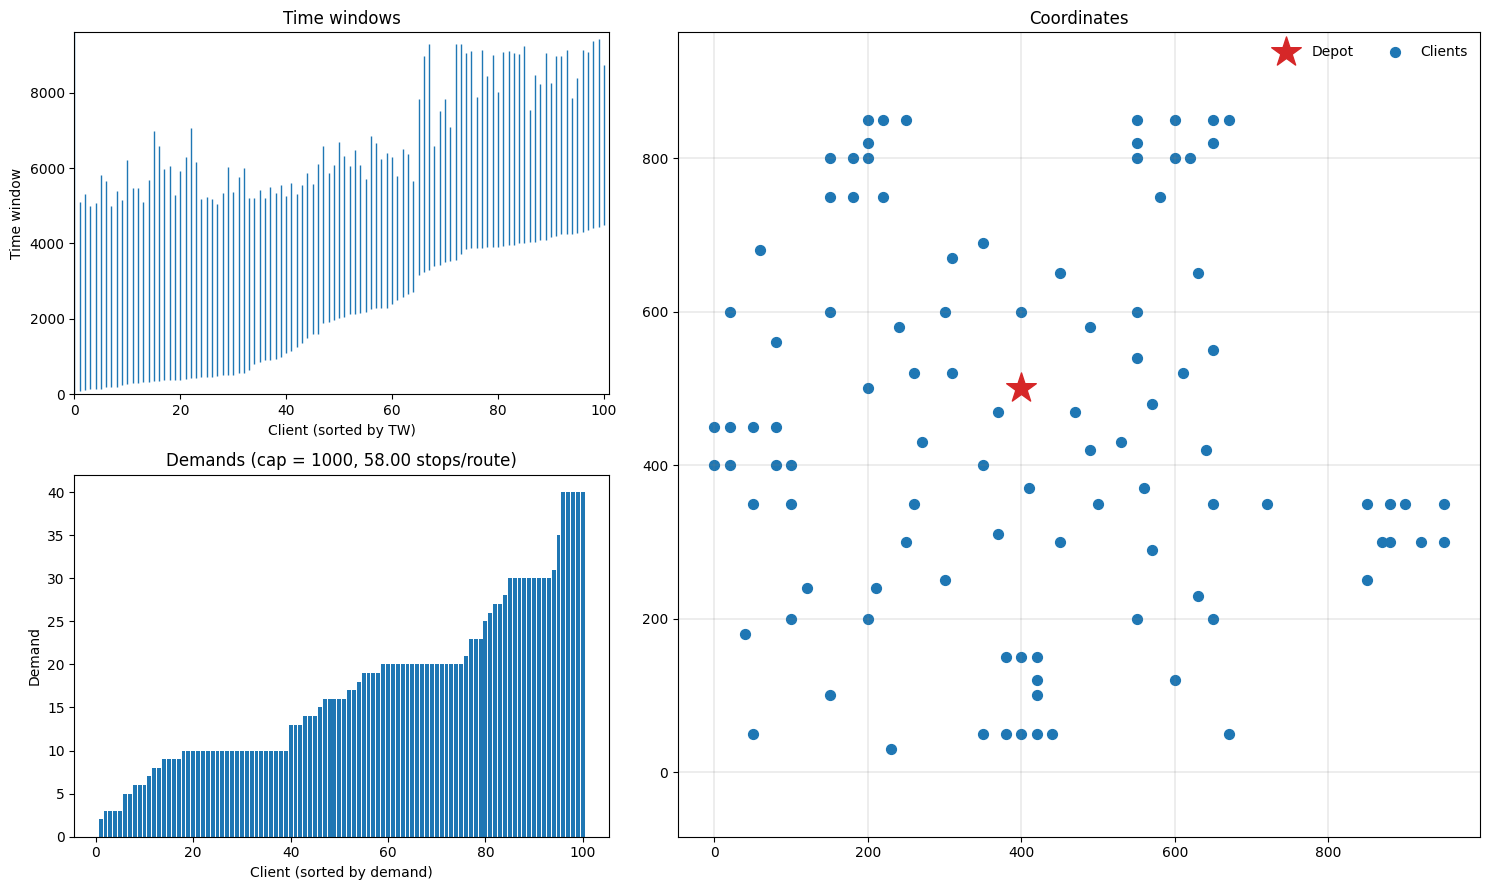

In [3]:
fig = plt.figure(figsize=(15, 9))
plotting.plot_instance(instance, fig)

### Configuring Hybrid Genetic Search
Now we will implement the `solve` function that sets up the necessary components of the Hybrid Genetic Search algorithm, which is a hybrid between a genetic algorithm and local search. The components include `Population`, `LocalSearch`, and the `PenaltyManager`. Then we will create the `GeneticAlgorithm` object and run it until our desired `StoppingCriterion` is met.

In [4]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)
    pop = Population(data, pen_manager, rng, bpd)
    ls = LocalSearch(data, pen_manager, rng, compute_neighbours(data))

    for op in NODE_OPERATORS:
        ls.add_node_operator(op(data, pen_manager))

    for op in ROUTE_OPERATORS:
        ls.add_route_operator(op(data, pen_manager))

    ga_params = GeneticAlgorithmParams(collect_statistics=True)
    algo = GeneticAlgorithm(data, pen_manager, rng, pop, ls, srex, ga_params)

    if max_runtime is not None:
        stop = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

### Solving an instance

Now let's run the algorithm using our `solve` function and compare the result with the best known solution.

In [5]:
def report_gap(result, bks, scale_factor=10):
    objective = result.best.cost() / scale_factor
    bks_cost = bks["cost"]
    pct_diff = 100 * (objective - bks_cost) / bks_cost

    print(f"Found a solution with cost: {objective}.")
    print(f"This is {pct_diff:.1f}% worse than the best known", end=" ")
    print(f"solution, which is {bks_cost}.")


result = solve(instance, seed=42, max_runtime=5)
report_gap(result, instance_bks)

Found a solution with cost: 776.1.
This is 0.0% worse than the best known solution, which is 776.1.


We've managed to find the best known solution in 5 seconds!

### Plot results
The `result` object (of type `Result`) contains useful statistics about the optimization since we set `collect_statistics=True` in `GeneticAlgorithmParams` (see the `solve` function). We can now plot these statistics as well as the final solution use `plotting.plot_result`.

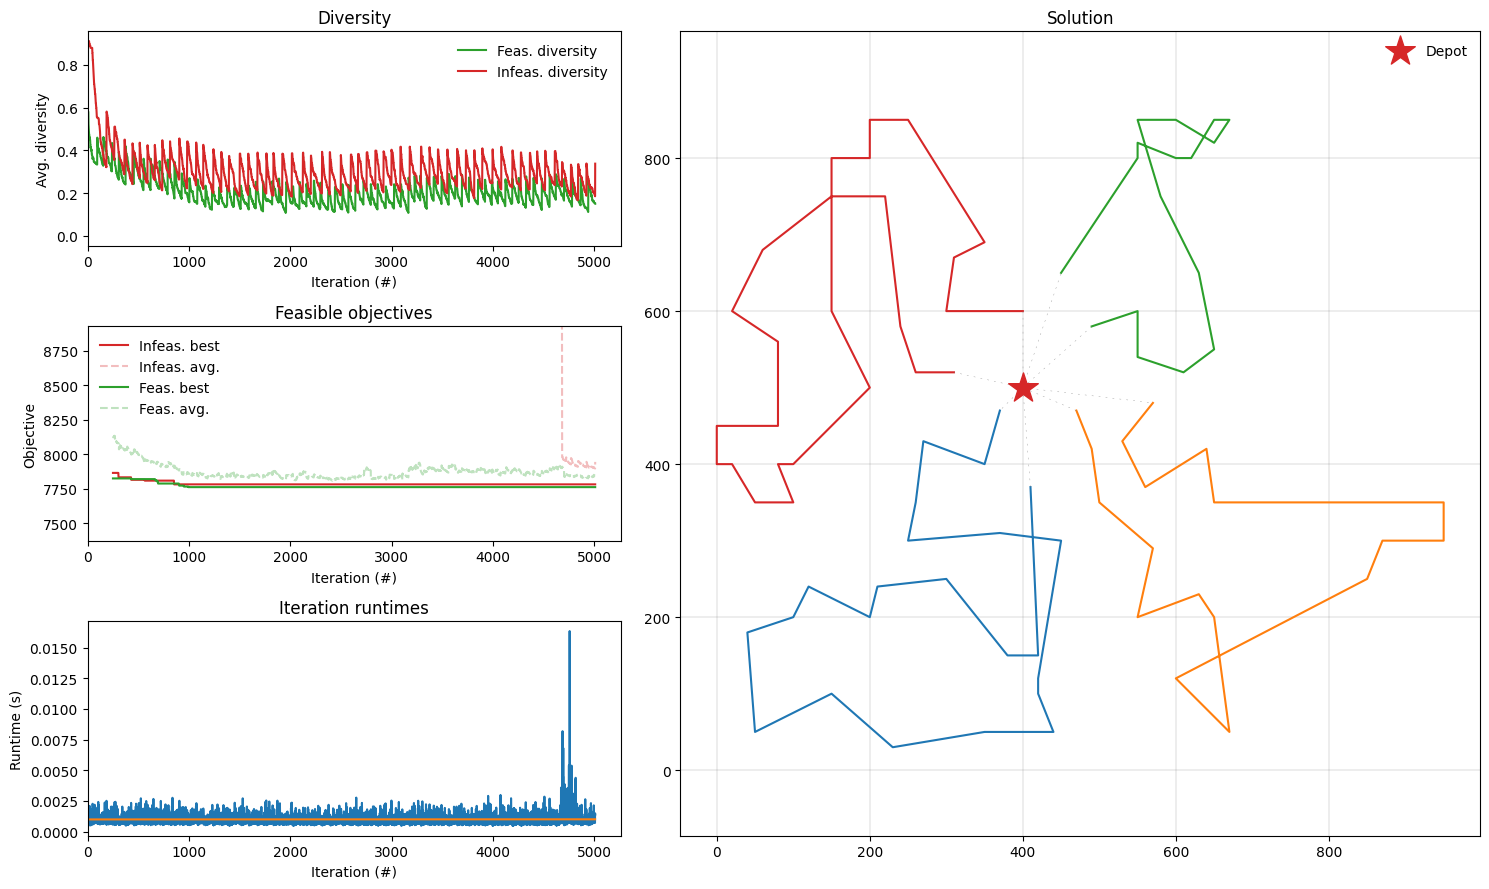

In [6]:
def plot_result(result, instance):
    fig = plt.figure(figsize=(15, 9))
    plotting.plot_result(result, instance, fig)
    fig.tight_layout()


plot_result(result, instance)

### Inspect routes
We can also inspect some statistics of the different routes, such as route distance and duration, number of stops and total demand, using `diagnostics.get_all_route_statistics`. Let's verify that the cost of our solution is equal to the sum of the distances.

In [7]:
solution = result.best
route_stats = diagnostics.get_all_route_statistics(solution, instance)
route_stats_df = pd.DataFrame(route_stats)

# Verify that cost is equal to total distance
assert route_stats_df["distance"].sum() == solution.cost()

display(route_stats_df.head())

,distance,start_time,end_time,duration,timewarp,wait_time,service_time,num_stops,total_demand,fillrate,is_feasible,is_empty
0,2187,0,7043,7043,0,2156,2700,27,465,0.465,True,False
1,1983,0,6862,6862,0,2479,2400,24,381,0.381,True,False
2,1325,0,6016,6016,0,2991,1700,17,286,0.286,True,False
3,2266,0,7295,7295,0,1829,3200,32,592,0.592,True,False


We can inspect the routes in more detail using the `plotting.plot_route_schedule` function. This will plot distance on the x-axis, and time on the y-axis, separating actual travel/driving time from waiting and service time. The clients visited are plotted as grey vertical bars indicating their time windows. When a vehicle arrives too early at a customer, we can see a jump to the start of the time window in the main (earliest) time line. In some cases, there is slack in the route indicated by a semi-transparent region on top of the earliest time line (see plot of Route 1). The grey background indicates the remaining load of the truck during the route, where the (right) y-axis ends at the vehicle capacity.

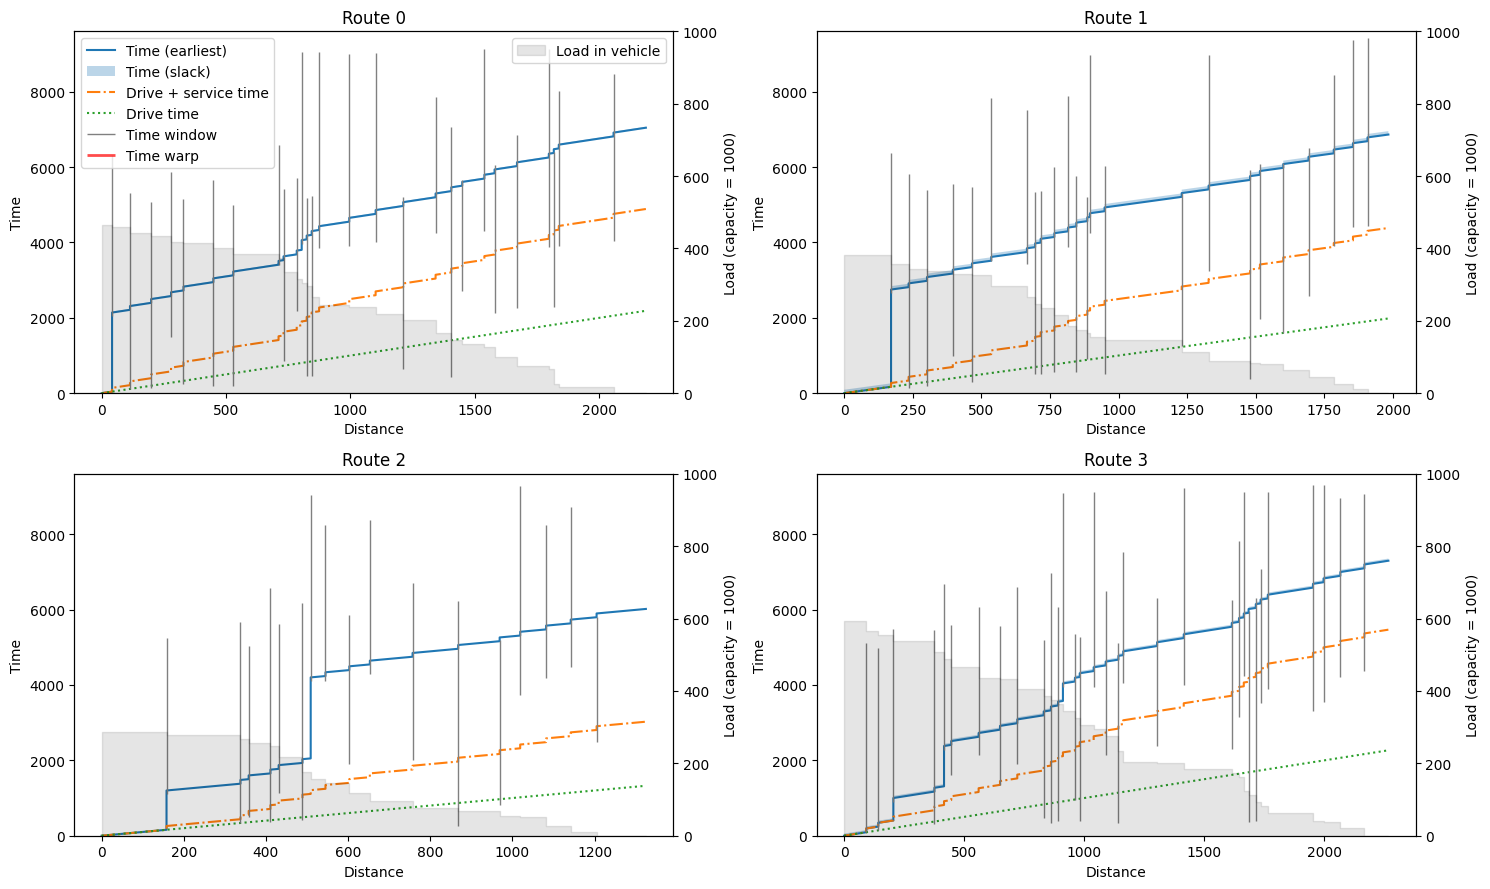

In [8]:
def plot_route_schedule(result, instance):
    fig, axarr = plt.subplots(2, 2, figsize=(15, 9))

    routes = result.best.get_routes()
    for idx, (ax, route) in enumerate(zip(axarr.reshape(-1), routes)):
        plotting.plot_route_schedule(
            instance, route, title=f"Route {idx}", ax=ax, legend=idx == 0
        )

    fig.tight_layout()


plot_route_schedule(result, instance)

## Solving larger instances

### Gehring & Homberger instance
Let's try one of the largest Gehring & Homberger instances (1000 customers), and plot the instance, results and some routes.

Found a solution with cost: 26394.9.
This is 2.3% worse than the best known solution, which is 25797.5.


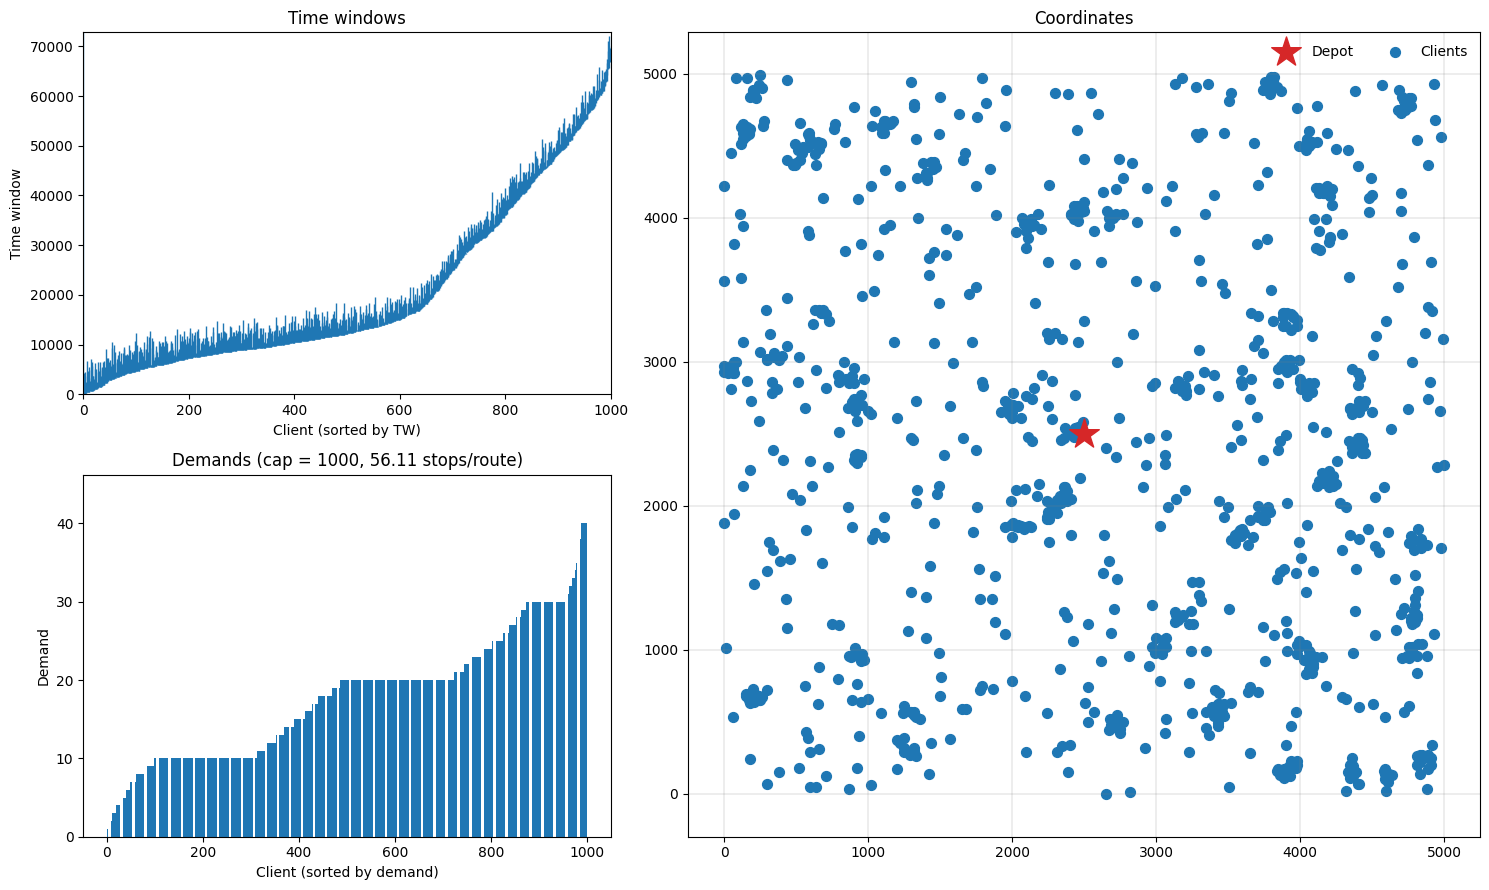

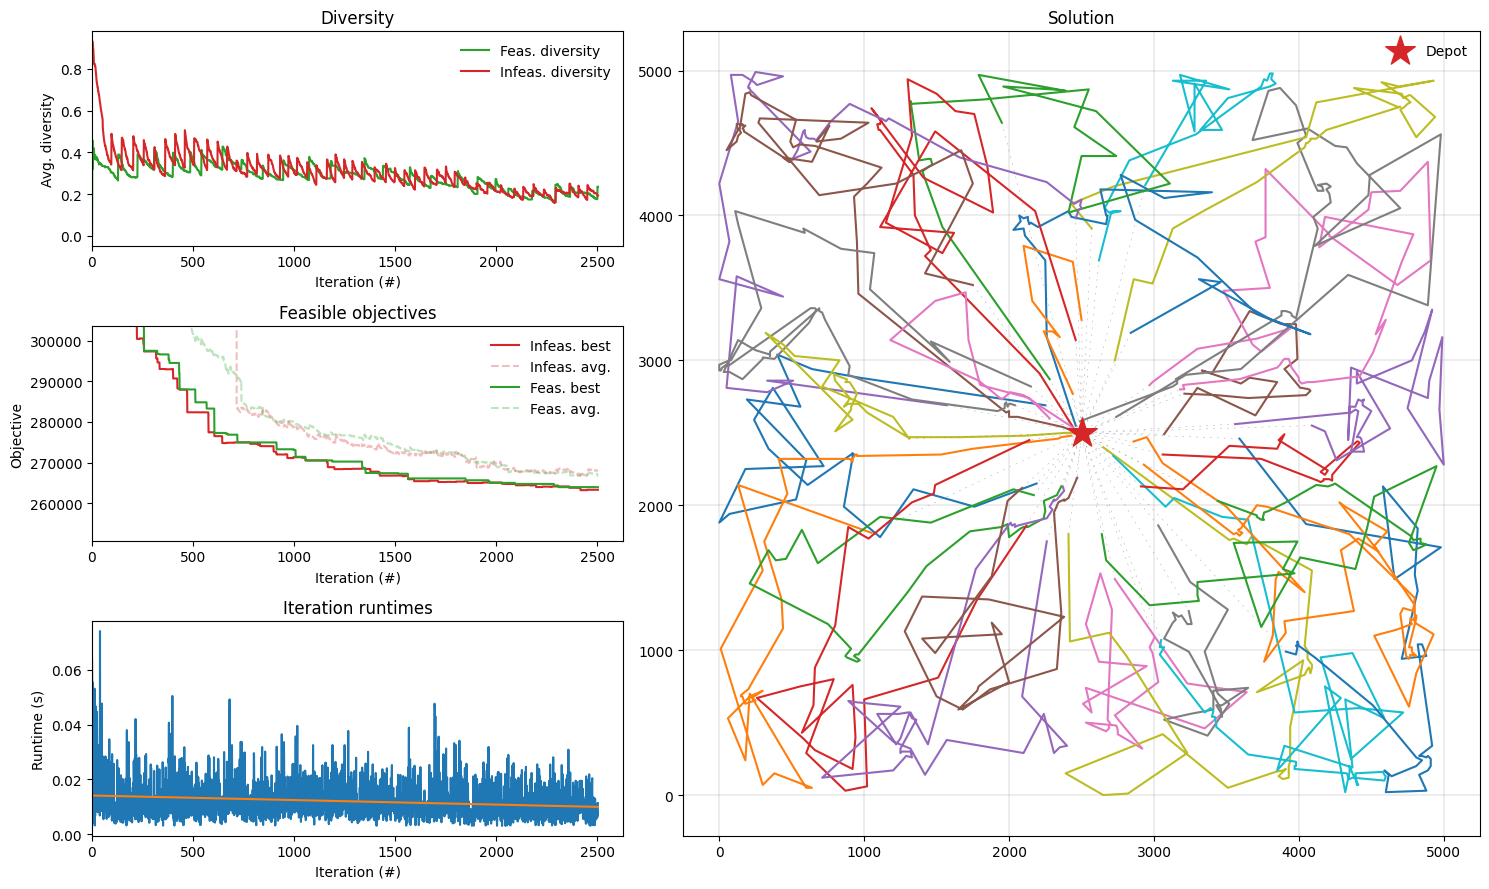

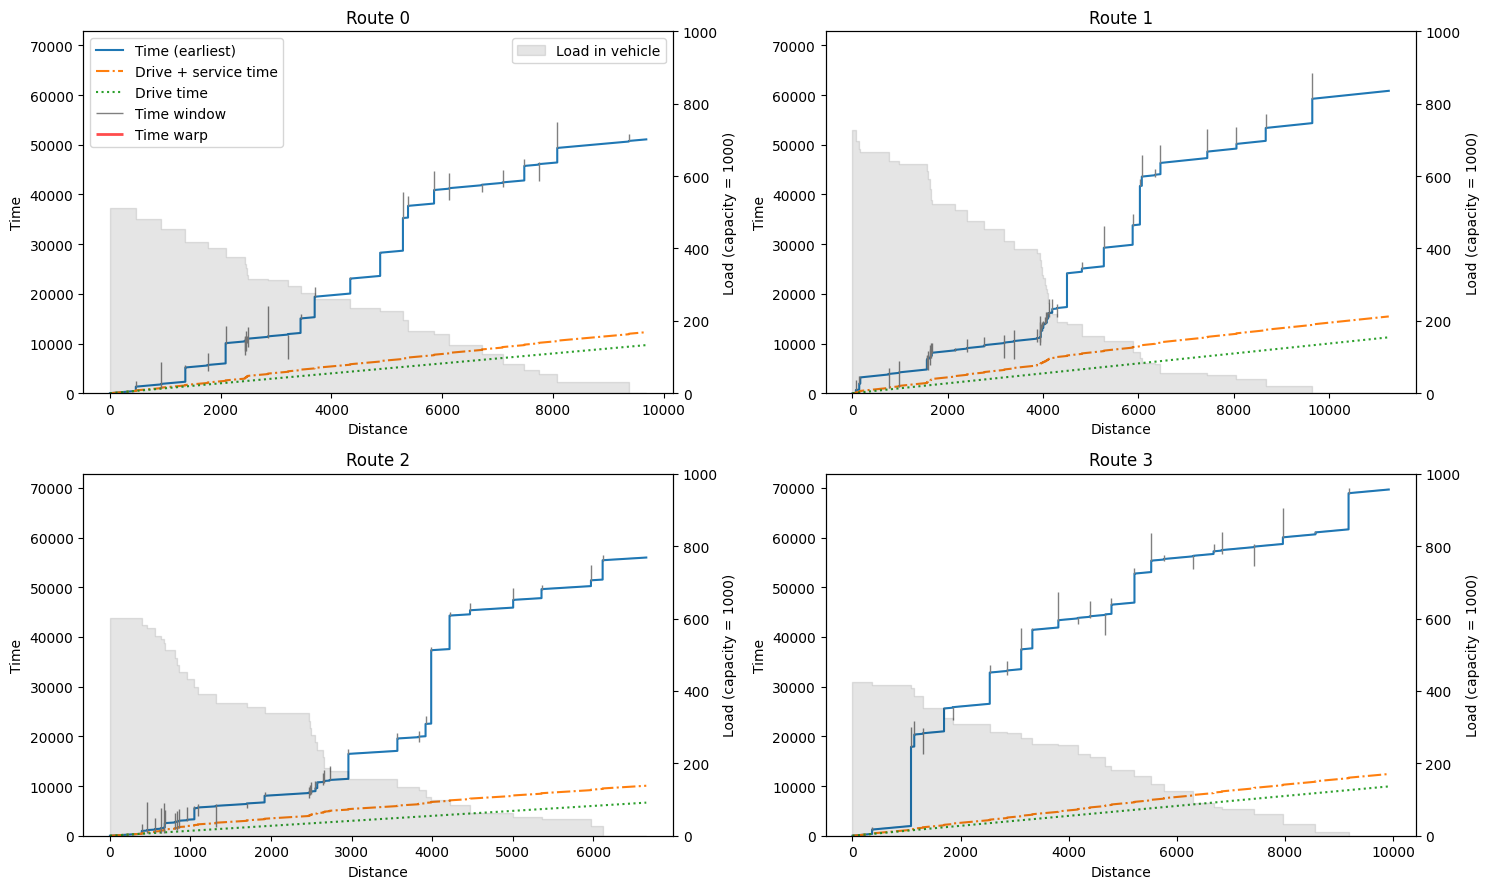

In [9]:
instance_gh = read(
    "data/RC2_10_5.vrp", instance_format="solomon", round_func="trunc1"
)
bks_gh = vrplib.read_solution("data/RC2_10_5.sol")

fig = plt.figure(figsize=(15, 9))
plotting.plot_instance(instance_gh, fig)

result_gh = solve(instance_gh, seed=42, max_runtime=30)

report_gap(result_gh, bks_gh)
plot_result(result_gh, instance_gh)
plot_route_schedule(result_gh, instance_gh)

### ORTEC instance (from the EURO Meets NeurIPS 2022 Competition)
Let's also try an instance based on real data, which uses an actual over-the-road distance matrix (non-Euclidean) and atypical client distribution. Note that the file is in VRPLIB format and the distances are already integral and so there is no rounding.

Found a solution with cost: 259601.0.
This is 0.3% worse than the best known solution, which is 258704.


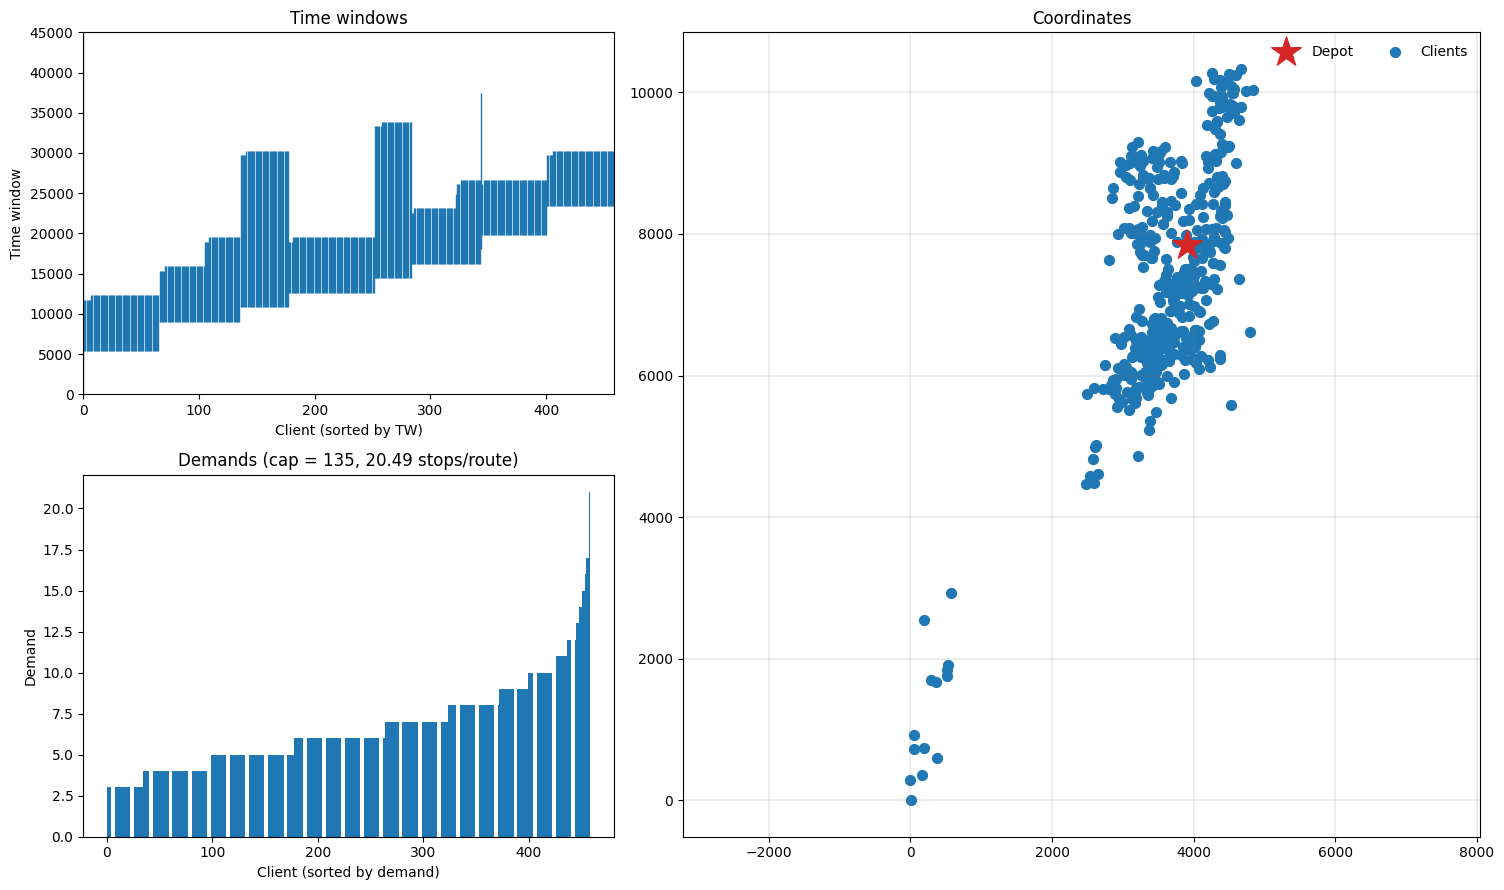

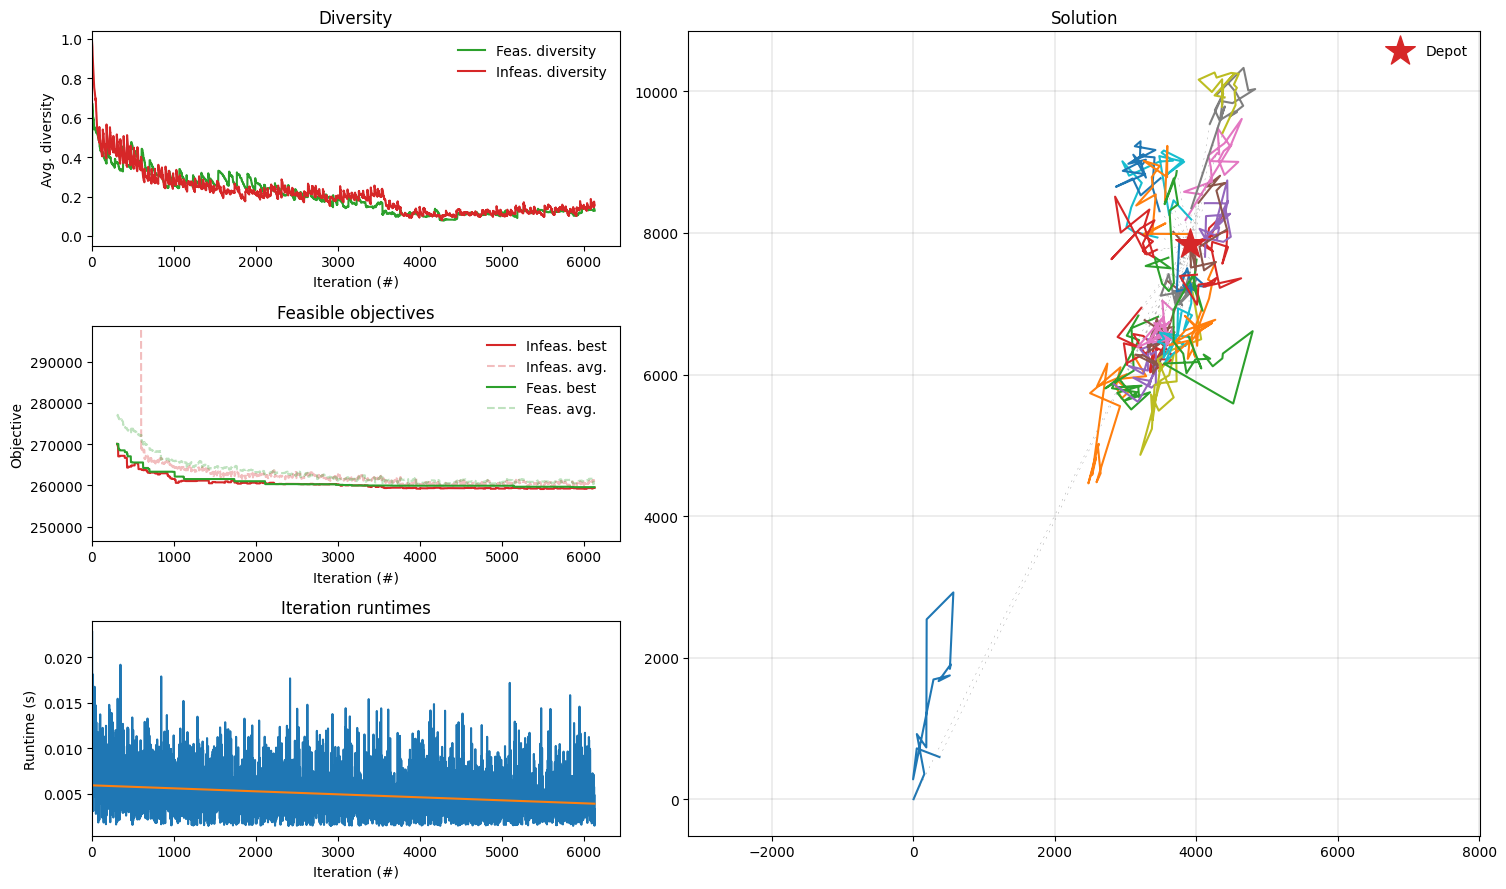

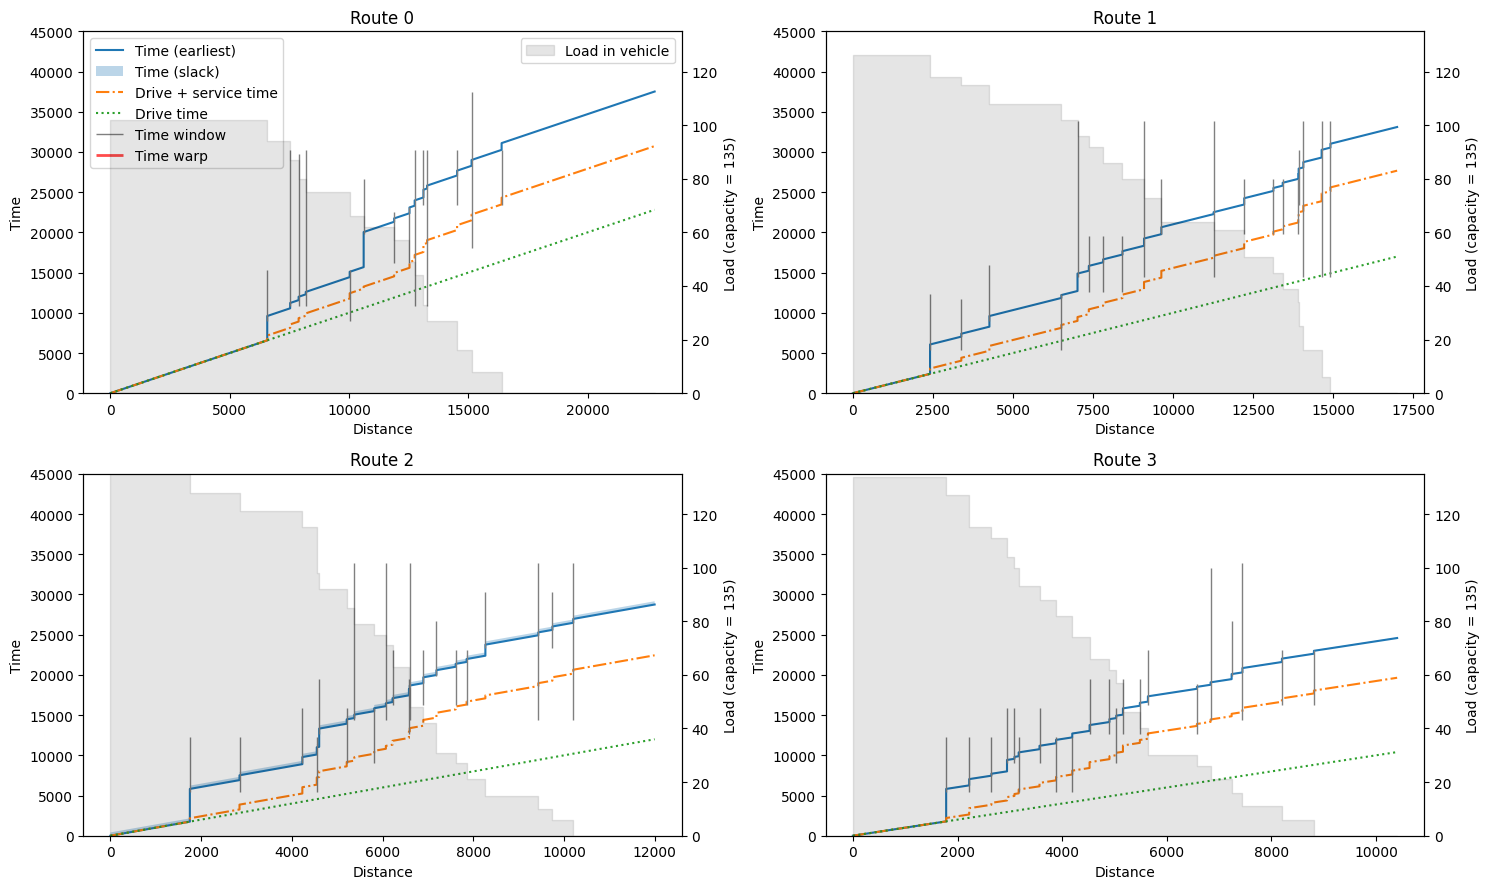

In [10]:
name_ortec = "ORTEC-VRPTW-ASYM-0bdff870-d1-n458-k35"
instance_ortec = read(f"data/{name_ortec}.txt")
bks_ortec = vrplib.read_solution(f"data/{name_ortec}.sol")

fig = plt.figure(figsize=(15, 9))
plotting.plot_instance(instance_ortec, fig)

result_ortec = solve(instance_ortec, seed=42, max_runtime=30)

report_gap(result_ortec, bks_ortec, scale_factor=1)
plot_result(result_ortec, instance_ortec)
plot_route_schedule(result_ortec, instance_ortec)

## Conclusion
In this notebook, we showed how to configure the Hybrid Genetic Search algorithm to solve the VRPTW. We run the solver on three different instances and we demonstrate how to use plotting and diagnostics utilities from the PyVRP library.